# Acquire

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
from math import sqrt
from statsmodels.formula.api import ols

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 

from env import host, user, password
import acquire
import prepare

sql_query = '''select *
    from  properties_2017
    join predictions_2017 using(parcelid)
    where transactiondate between "2017-05-01" and "2017-08-31"
        and propertylandusetypeid between 260 and 266
            or propertylandusetypeid between 273 and 279
            and not propertylandusetypeid = 274
        and unitcnt = 1;
    '''
connection = f'mysql+pymysql://{user}:{password}@{host}/zillow'
df = pd.read_sql(sql_query, connection)

In [2]:
df = acquire.acquire_zillow()
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,None,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,None,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,None,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,None,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,None,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,None,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30


# Prep

#### Drop all columns that have less that 35,000 non null values

In [3]:
df = df.dropna(axis=1,thresh=35000)

#### Add new features

In [4]:
df['house_age'] = 2021 - df.yearbuilt

In [5]:
df['tax_rate'] = df.taxvaluedollarcnt / df.taxamount

In [6]:
df.head()

,parcelid,id,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,id,logerror,transactiondate,house_age,tax_rate
0,14634203,2026522,2.0,3.0,2.0,1125.0,1125.0,6059.0,2.0,33922098.0,...,289445.0,2016.0,213516.0,3490.16,6.059001e+13,625,-0.061973,2017-08-04,47.0,82.931728
1,11721753,616260,2.0,3.0,2.0,1316.0,1316.0,6037.0,2.0,34033180.0,...,205123.0,2016.0,163175.0,2627.48,6.037220e+13,1018,0.017785,2017-07-21,98.0,78.068339
2,11289917,2061546,2.0,3.0,2.0,1458.0,1458.0,6037.0,2.0,34686163.0,...,136104.0,2016.0,27214.0,2319.90,6.037901e+13,1248,-0.362001,2017-06-23,51.0,58.668046
3,11637029,2554497,2.0,3.0,2.0,1766.0,1766.0,6037.0,2.0,34073222.0,...,810694.0,2016.0,554156.0,9407.01,6.037701e+13,1734,-0.093399,2017-07-28,41.0,86.179774
4,11705026,1834372,1.0,2.0,1.0,1421.0,1421.0,6037.0,1.0,33999877.0,...,35606.0,2016.0,23624.0,543.69,6.037232e+13,1772,-0.146056,2017-06-30,110.0,65.489525


#### Delete columns:
- `calculatedbathnbr`
    - because we already have the finished number of bathrooms
- `finishedsquarefeet12`
    - because we have our finished square feet already
- `propertycountylandusecode`
    - because we have the id for this already
- `propertyzoningdesc`
    - because it is not that helpful
- `logerror`
    - because logerror is an unknown feature in data dictonary
- `transactiondate`
    - because it is not that helpful
- `yearbuilt`
    - because it would not be read as a year but as a numeric value
- `taxvaluedollarcnt`
    - using this would be cheating
- `landtaxvaluedollarcnt`
    - using this would be cheating
- `taxvaluedollarcnt`
    - using this would be cheating
- `rawcensustractandblock`
    - because it is uneeded
- `censustractandblock`
    - because it is uneeded

In [7]:
df = df.drop(['calculatedbathnbr', 'finishedsquarefeet12', 
             'propertycountylandusecode', 'logerror', 'transactiondate',  
             'yearbuilt', 'landtaxvaluedollarcnt', 
              'rawcensustractandblock', 'censustractandblock', 
              'structuretaxvaluedollarcnt', 'parcelid', 'id'], axis=1)

In [8]:
df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,propertylandusetypeid,regionidcity,regionidcounty,regionidzip,roomcnt,taxvaluedollarcnt,assessmentyear,taxamount,house_age,tax_rate
0,2.0,3.0,1125.0,6059.0,2.0,33922098.0,-117954970.0,266.0,18874.0,1286.0,96186.0,6.0,289445.0,2016.0,3490.16,47.0,82.931728
1,2.0,3.0,1316.0,6037.0,2.0,34033180.0,-118355396.0,261.0,12447.0,3101.0,95997.0,0.0,205123.0,2016.0,2627.48,98.0,78.068339
2,2.0,3.0,1458.0,6037.0,2.0,34686163.0,-118113100.0,261.0,5534.0,3101.0,97318.0,0.0,136104.0,2016.0,2319.90,51.0,58.668046
3,2.0,3.0,1766.0,6037.0,2.0,34073222.0,-118390965.0,266.0,10389.0,3101.0,96086.0,0.0,810694.0,2016.0,9407.01,41.0,86.179774
4,1.0,2.0,1421.0,6037.0,1.0,33999877.0,-118291863.0,261.0,12447.0,3101.0,96018.0,0.0,35606.0,2016.0,543.69,110.0,65.489525


#### Rename columns:
- `bathroomcnt` to "**bathrooms**"
- `bedroomcnt` to "**bedrooms**"
- `calculatedfinishedsquarefeet` to "**house_square_feet**"
- `fullbathcnt` to "**full_baths**"
- `regionidzip` to "**zip_code**"
- `regionidcity` to "**city**"

In [9]:
df = df.rename(columns={'bathroomcnt':'bathrooms', 'bedroomcnt':'bedrooms', 
                       'calculatedfinishedsquarefeet':'square_feet', 
                       'fullbathcnt':'full_baths', 'regionidzip':'zip_code', 
                       'regionidcity':'city', 'regionidcounty':'county',
                       'taxvaluedollarcnt':'appraised_value', 
                        'propertylandusetypeid':'house_type'})

#### Drop null values left over

In [10]:
df = df.dropna()

- this ended up dropping from 38582 to 37712
    - we lost 870 rows by dropping

## Handle outliers

<AxesSubplot:title={'center':'Distribution of Appraised Values'}, xlabel='appraised_value'>

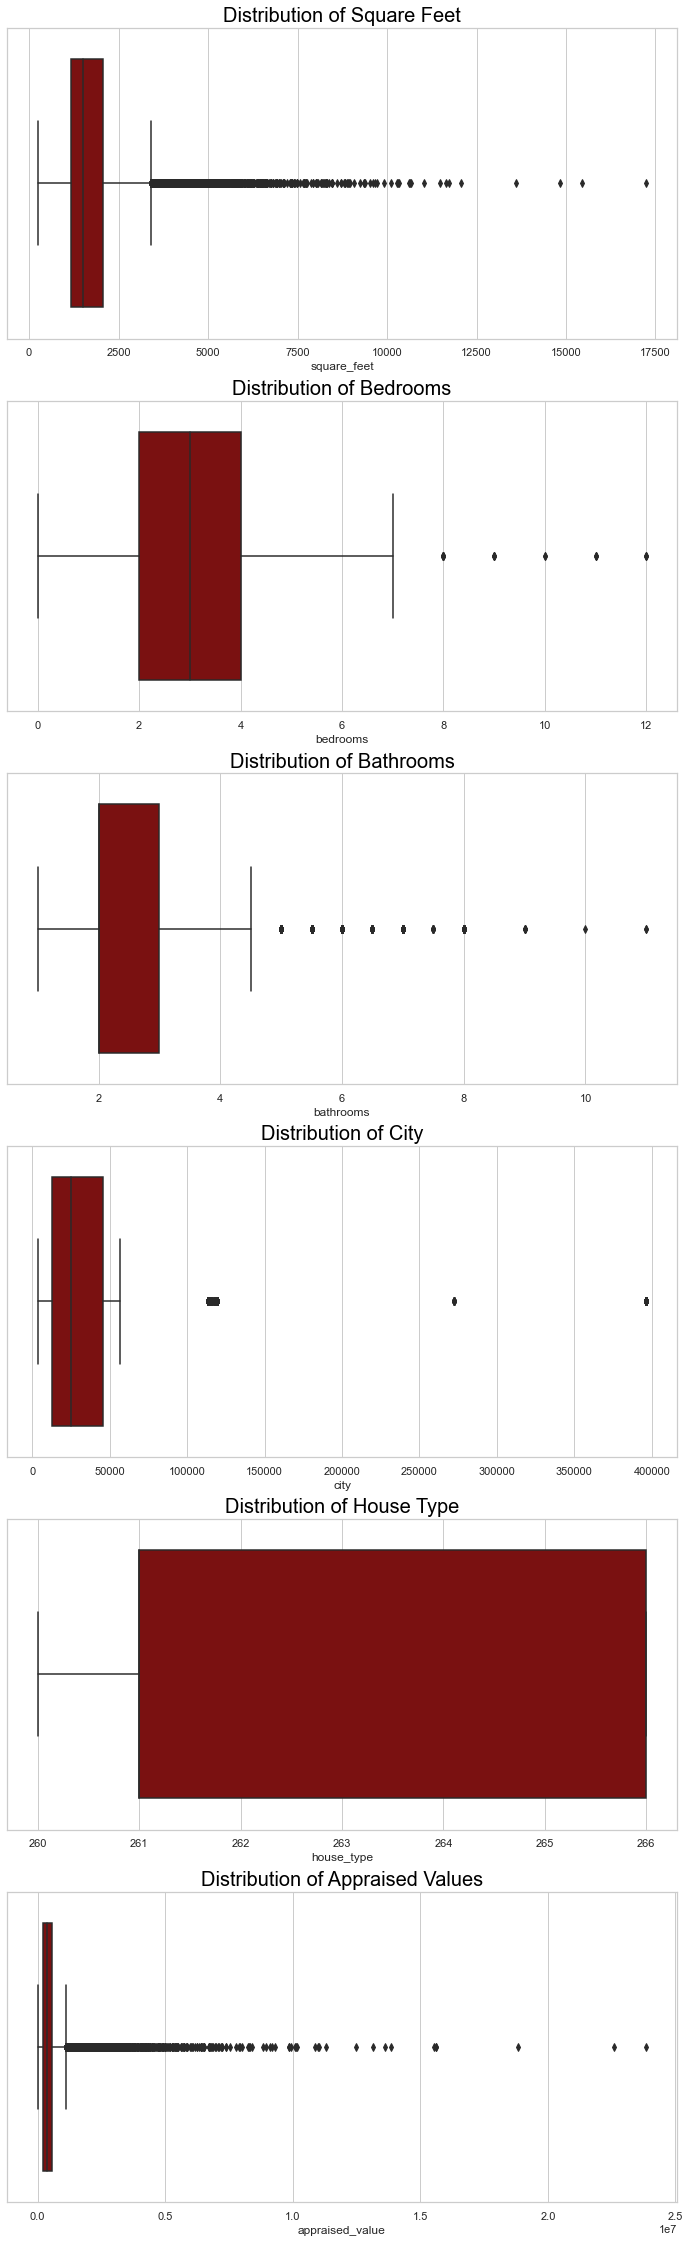

In [11]:
plt.subplots(6, 1, figsize=(12,40), sharey=True)
sns.set(style="whitegrid")

plt.subplot(6,1,1)
plt.title("Distribution of Square Feet", size=20, color='black')
sns.boxplot(df.square_feet, color='darkred')
    
plt.subplot(6,1,2)
plt.title("Distribution of Bedrooms", size=20, color='black')
sns.boxplot(df.bedrooms, color='darkred')

plt.subplot(6,1,3)
plt.title("Distribution of Bathrooms", size=20, color='black')
sns.boxplot(df.bathrooms, color='darkred')

plt.subplot(6,1,4)
plt.title("Distribution of City", size=20, color='black')
sns.boxplot(df.city, color='darkred')

plt.subplot(6,1,5)
plt.title("Distribution of House Type", size=20, color='black')
sns.boxplot(df.house_type, color='darkred')

plt.subplot(6,1,6)
plt.title("Distribution of Appraised Values", size=20, color='black')
sns.boxplot(df.appraised_value, color='darkred')

- Takeaways from boxplots:
    - `appraised_value` has an extreme amount of outliers
        - I will have to remove because they are skewing the data far too much
            - handled using IQR rule
    - `square_feet` also has too many outliers
        - I will remove these as well because of their affect the data.
            - handled using IQR rule
    - `bathrooms
        - have some outliers
            - did not handle due to having to loose 6,880 if I did so
    - `bedrooms`
        - have some outliers
            - handled using IQR rule
    - `city`
        - have some outliers
            - did not handle these outliers due to amount of rows lost if done so
    

- My questions:
    - What is causing these outliers?
        - Are there typos?
            - Probably not this is southern california the state of overpriced housing.
    - How will I go about removing these outliers?
    - Is there anything I should remove from the data?

#### Handle Outliers of appraised_value

<AxesSubplot:title={'center':'Distribution of Appraised Values'}, xlabel='appraised_value'>

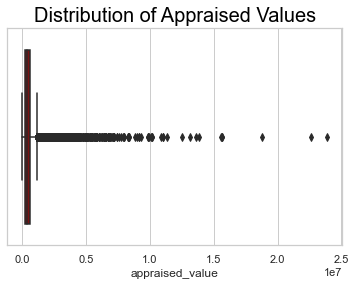

In [12]:
# boxplot before handling our outliers
plt.title("Distribution of Appraised Values", size=20, color='black')
sns.boxplot(df.appraised_value, color='darkred')

- `appraised_value` has an extreme amount of outliers
    - I will have to remove because they are skewing the data far too much
        - I will do this by using the IQR rule

In [13]:
df.appraised_value.describe()

count    3.769200e+04
mean     4.937715e+05
std      6.273602e+05
min      1.000000e+03
25%      2.080300e+05
50%      3.620010e+05
75%      5.742248e+05
max      2.385837e+07
Name: appraised_value, dtype: float64

In [14]:
# Let's use IQR for the entire dataset
q1 = df.appraised_value.quantile(.25)
q3 = df.appraised_value.quantile(.75)
iqr = q3 - q1

print(f'q1 = :', q1) 
print(f'q3 = :', q3)
print(f'IQR = :', iqr)

q1 = : 208030.0
q3 = : 574224.75
IQR = : 366194.75


In [15]:
# IQR has a parameter that is a 'multiplier'
multiplier = 1.5
upper_bound = q3 + (multiplier * iqr)
lower_bound = q1 - (multiplier * iqr)

print(f'Upper Bound = :', upper_bound) 
print(f'Lower Bound = :', lower_bound) 
# since the lower bound is the negatives, it will have no affect

Upper Bound = : 1672809.0
Lower Bound = : -890554.25


In [16]:
df.shape

(37692, 17)

In [17]:
# lets say give us everyhting less than the upper bound
df = df[df.appraised_value < upper_bound]
df.shape
# df have gone from 37,711 rows to 35,187 rows
    # the df has lost 2,524 rows

(36561, 17)

<AxesSubplot:title={'center':'Distribution of Appraised Values without Outliers'}, xlabel='appraised_value'>

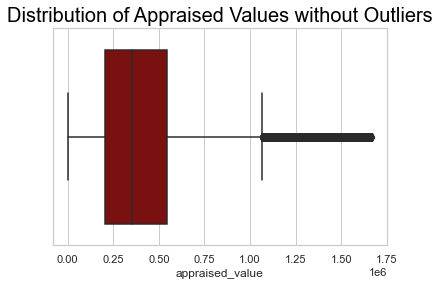

In [18]:
# boxplot before handling our outliers
plt.title("Distribution of Appraised Values without Outliers", size=20, color='black')
sns.boxplot(df.appraised_value, color='darkred')

##### Use this in the prepare.py clean_zillow function

In [19]:
df = df[df.appraised_value <= 1_123_603.75]

#### Handle Outliers of square_feet

<AxesSubplot:title={'center':'Distribution of Square Feet with Outliers'}, xlabel='square_feet'>

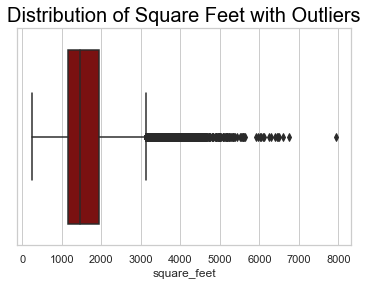

In [20]:
# boxplot before handling our outliers
plt.title("Distribution of Square Feet with Outliers", size=20, color='black')
sns.boxplot(df.square_feet, color='darkred')

- `square_feet` also has too many outliers
    - I will remove these as well because of their affect the data.
        - I will remove them using the IQR rule

In [21]:
df.square_feet.describe()

count    35170.000000
mean      1626.094143
std        685.079619
min        240.000000
25%       1149.000000
50%       1472.000000
75%       1941.000000
max       7942.000000
Name: square_feet, dtype: float64

In [22]:
# Let's use IQR for the entire dataset
q1 = df.square_feet.quantile(.25)
q3 = df.square_feet.quantile(.75)
iqr = q3 - q1

print(f'q1 = :', q1) 
print(f'q3 = :', q3)
print(f'IQR = :', iqr)

q1 = : 1149.0
q3 = : 1941.0
IQR = : 792.0


In [23]:
# IQR has a parameter that is a 'multiplier'
multiplier = 1.5
upper_bound = q3 + (multiplier * iqr)
lower_bound = q1 - (multiplier * iqr)

print(f'Upper Bound = :', upper_bound) 
print(f'Lower Bound = :', lower_bound) 
# since the lower bound is the negatives, it will have no affect

Upper Bound = : 4317.0
Lower Bound = : -1227.0


In [24]:
df.shape

(35170, 17)

In [25]:
# lets say give us everyhting less than the upper bound
df = df[df.square_feet < upper_bound]
df.shape
# df have gone from 35,187 rows to 33,849 rows
    # the df has lost 1,338 rows

(35033, 17)

<AxesSubplot:title={'center':'Distribution of Square Feet without Outliers'}, xlabel='square_feet'>

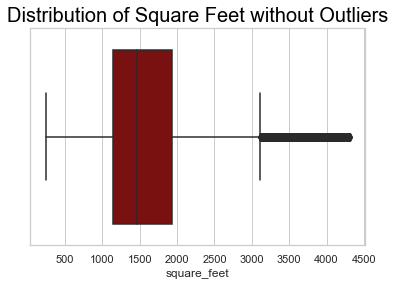

In [26]:
# boxplot before handling our outliers
plt.title("Distribution of Square Feet without Outliers", size=20, color='black')
sns.boxplot(df.square_feet, color='darkred')

##### Use this in the prepare.py clean_zillow function

In [27]:
df = df[df.square_feet <= 3_131.5]

#### Handle Outliers of bedrooms

<AxesSubplot:title={'center':'Distribution of Bedrooms with Outliers'}, xlabel='bedrooms'>

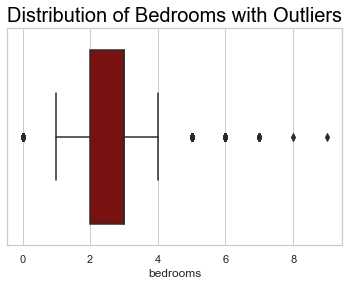

In [28]:
# boxplot before handling our outliers
plt.title("Distribution of Bedrooms with Outliers", size=20, color='black')
sns.boxplot(df.bedrooms, color='darkred')

- `bedrooms`
    - have some outliers

In [29]:
df.bedrooms.describe()

count    33834.000000
mean         2.894012
std          0.927546
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          9.000000
Name: bedrooms, dtype: float64

In [30]:
# Let's use IQR for the entire dataset
q1 = df.bedrooms.quantile(.25)
q3 = df.bedrooms.quantile(.75)
iqr = q3 - q1

print(f'q1 = :', q1) 
print(f'q3 = :', q3)
print(f'IQR = :', iqr)

q1 = : 2.0
q3 = : 3.0
IQR = : 1.0


In [31]:
# IQR has a parameter that is a 'multiplier'
multiplier = 1.5
upper_bound = q3 + (multiplier * iqr)
lower_bound = q1 - (multiplier * iqr)

print(f'Upper Bound = :', upper_bound) 
print(f'Lower Bound = :', lower_bound) 

Upper Bound = : 6.0
Lower Bound = : -1.0


In [32]:
df.shape

(33834, 17)

In [33]:
# filter out the low outliers
df = df[df.bedrooms > lower_bound]

# lets say give us everyhting less than the upper bound
df = df[df.bedrooms < upper_bound]

df.shape
# df have gone from 33,849 rows to 32,538 rows
    # the df has lost 1,311 rows

(33713, 17)

<AxesSubplot:title={'center':'Distribution of Bedrooms without Outliers'}, xlabel='bedrooms'>

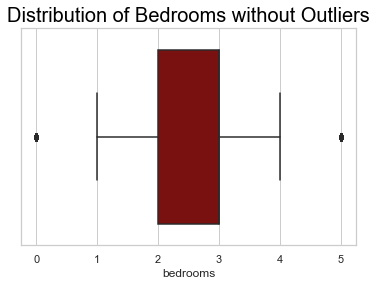

In [34]:
# boxplot before handling our outliers
plt.title("Distribution of Bedrooms without Outliers", size=20, color='black')
sns.boxplot(df.bedrooms, color='darkred')

##### Use this in the prepare.py clean_zillow function

In [35]:
df = df[df.square_feet <= 4.5]
df = df[df.square_feet >= 0.5]

In [36]:
df.head()

,bathrooms,bedrooms,square_feet,fips,full_baths,latitude,longitude,house_type,city,county,zip_code,roomcnt,appraised_value,assessmentyear,taxamount,house_age,tax_rate


In [37]:
df = acquire.acquire_zillow()

In [38]:
df = prepare.clean_zillow(df)

Text(0.5, 1.0, 'Zillow Correlation Heatmap of Trained Data without Scaling')

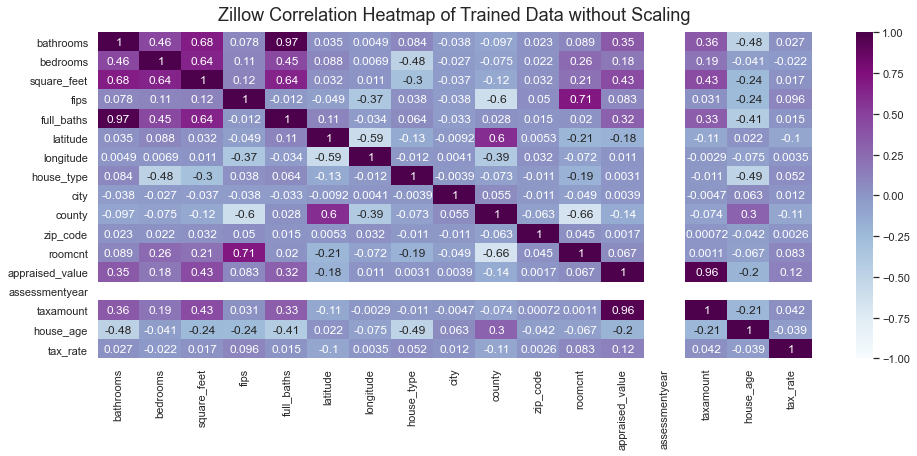

In [39]:
plt.figure(figsize=(16, 6))
corr_map = sns.heatmap(df.corr(), cmap="BuPu", vmin=-1, vmax=1, annot=True)
corr_map.set_title('Zillow Correlation Heatmap of Trained Data without Scaling', fontdict={'fontsize':18}, pad=12)
# '-' (negative) is still correlation but is downward slope not upward

- Takeaways
    - my target is `appraised_value`
        - strongest correlations are
            - square_feet
                - 0.61
            - bathrooms
                - 0.51
            - bedrooms
                - 0.29
            - house_age
                - 0.13
            - lattitude
                - 0.11
            - house_type
                - 0.1

Lets focus on some features

In [40]:
df = prepare.focused_zillow(df)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32542 entries, 0 to 38581
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   square_feet      32542 non-null  float64
 1   bedrooms         32542 non-null  float64
 2   bathrooms        32542 non-null  float64
 3   appraised_value  32542 non-null  float64
dtypes: float64(4)
memory usage: 1.2 MB


In [42]:
df.describe()

,square_feet,bedrooms,bathrooms,appraised_value
count,32542.000000,32542.000000,32542.000000,3.254200e+04
mean,1517.124209,2.824196,2.074642,3.644769e+05
std,529.219531,0.821697,0.693076,2.270200e+05
min,242.000000,1.000000,1.000000,1.050400e+04
25%,1130.000000,2.000000,2.000000,1.915722e+05
50%,1424.000000,3.000000,2.000000,3.294540e+05
75%,1818.000000,3.000000,2.500000,4.929138e+05
max,3130.000000,4.000000,7.500000,1.123324e+06


In [43]:
df.value_counts()

square_feet  bedrooms  bathrooms  appraised_value
610.0        1.0       1.0        258000.0           5
680.0        1.0       1.0        326000.0           5
648.0        1.0       1.0        328000.0           4
1267.0       2.0       2.5        538000.0           4
610.0        1.0       1.0        215131.0           4
                                                    ..
1662.0       3.0       2.0        93973.0            1
                                  117249.0           1
                                  277052.0           1
                                  299140.0           1
242.0        1.0       1.0        62381.0            1
Length: 32353, dtype: int64

In [44]:
df.isna().sum()

square_feet        0
bedrooms           0
bathrooms          0
appraised_value    0
dtype: int64

In [45]:
df.isnull().sum()
# woohoo no more nulls

square_feet        0
bedrooms           0
bathrooms          0
appraised_value    0
dtype: int64

In [46]:
df.square_feet.unique

<bound method Series.unique of 0        1125.0
1        1316.0
2        1458.0
3        1766.0
4        1421.0
          ...  
38575     900.0
38576    1187.0
38578     769.0
38579    1212.0
38581    1574.0
Name: square_feet, Length: 32542, dtype: float64>

In [47]:
df.bedrooms.unique()

array([3., 2., 4., 1.])

In [48]:
df.bathrooms.unique()

array([2. , 1. , 3. , 1.5, 2.5, 4. , 3.5, 4.5, 6. , 5. , 7.5])

In [49]:
df.appraised_value.unique

<bound method Series.unique of 0        289445.0
1        205123.0
2        136104.0
3        810694.0
4         35606.0
           ...   
38575    119659.0
38576    465999.0
38578    492395.0
38579    600608.0
38581    563463.0
Name: appraised_value, Length: 32542, dtype: float64>

Lets split the data into train, validate, and test.

In [50]:
train, validate, test = prepare.split_focused_zillow(df)
train.head()

,square_feet,bedrooms,bathrooms,appraised_value
31538,1050.0,2.0,1.0,292000.0
5911,715.0,1.0,1.0,97093.0
20091,2097.0,2.0,2.0,80091.0
36157,1216.0,3.0,1.0,34746.0
1799,1523.0,3.0,3.0,177000.0


In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18223 entries, 31538 to 20146
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   square_feet      18223 non-null  float64
 1   bedrooms         18223 non-null  float64
 2   bathrooms        18223 non-null  float64
 3   appraised_value  18223 non-null  float64
dtypes: float64(4)
memory usage: 711.8 KB
